In [28]:
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn.functional as F
from pprint import pprint
from utils.metrics import dice_batch

sns.set_theme(
    context="notebook",
    style="whitegrid",
    # palette="deep",
    # font="serif",
    font_scale=1.0,
    color_codes=True,
    rc={"figure.dpi": 150},
)
categories = ["Background", "Esophagus", "Heart", "Trachea", "Aorta"]
K = len(categories)

curdir = Path.cwd()
sys.path.append(str(curdir.parent))

results_path = curdir.parent / "results"
data_path = curdir.parent / "data"

DATASET = "segthor_train"  # 3D
MODEL_NAME = "segvol"

experiments_path = results_path / DATASET
_experiments = sorted(list(filter(lambda x: x.is_dir(), experiments_path.iterdir())))
print("Found experiments:")
for i, exp in enumerate(_experiments):
    print(f"{i}: {exp.name}")

experiments = list(filter(lambda x: MODEL_NAME in x.name.lower(), _experiments))

methods = [
    ("SegVol Zero-shot", experiments[0]),
    ("SegVol w/ D+CE", experiments[1]),
    ("SegVol w/ D+CE+Aug", experiments[2]),
    ("SegVol w/ D+F", experiments[3]),
    ("SegVol w/ D+F+Aug", experiments[4]),
]


Found experiments:
0: nnUNet
1: segvol_0_zeroshot
2: segvol_1_dicece_lr0.0005_e50_noaug
3: segvol_2_dicece_lr0.0005_e50_aug
4: segvol_3_dicefocal_lr0.0005_e50_noaug
5: segvol_4_dicefocal_lr0.0005_e50_aug


In [122]:
def process_experiment(experiment):
    # This assumes you have a folder with results as PatientID.nii.gz   
    patients = list(filter(lambda x: ".nii.gz" in x.name, experiment.iterdir()))

    store = np.zeros((len(patients), K))
    gt_path = data_path / dataset / "train"
    for i, patient in enumerate(patients):
        patient_id = patient.stem.split(".")[0] # PatientID.nii.gz -> PatientID
        print(patient_id)
        pred = np.asarray(nib.load(patient).dataobj)
        gt = np.asarray(nib.load(gt_path / patient_id / "GT.nii.gz").dataobj)
        pred, gt = torch.from_numpy(pred), torch.from_numpy(gt)
        pred, gt = (
            F.one_hot(pred.long(), K).permute(3, 0, 1, 2),
            F.one_hot(gt.long(), K).permute(3, 0, 1, 2),
        )
        dice = dice_batch(gt.unsqueeze(0), pred.unsqueeze(0))
        store[i] = dice.cpu().numpy()
        del pred, gt
        print(dice)

    np.save(experiment / "dice_pred.npy", store)


# process_experiment(experiments[0])
# process_experiment(experiments[1])

## SegVol plot comparisons

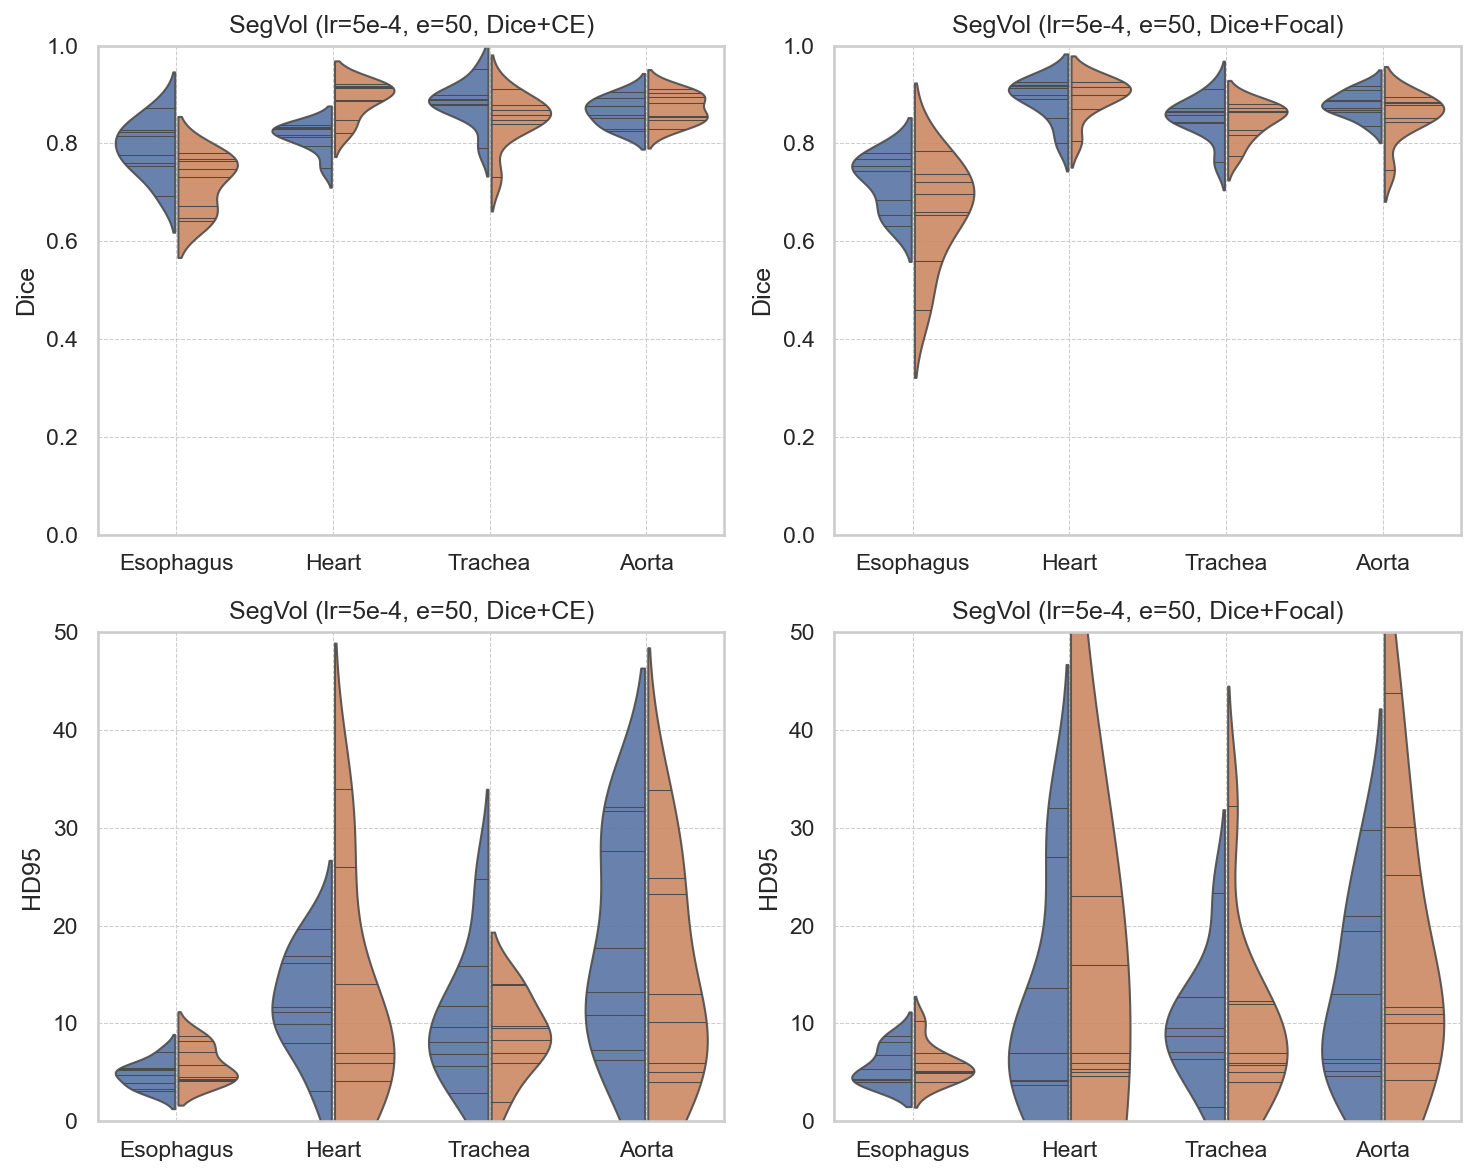

In [30]:
fig, ax = plt.subplots(2,2, figsize=(10, 8))
ax[0,0].set(ylabel="Dice", ylim=(0, 1), title="SegVol (lr=5e-4, e=50, Dice+CE)")
ax[1, 0].set(ylabel="HD95", ylim=(0, 50), title="SegVol (lr=5e-4, e=50, Dice+CE)")

ax[0, 1].set(ylabel="Dice", ylim=(0, 1), title="SegVol (lr=5e-4, e=50, Dice+Focal)")
ax[1, 1].set(ylabel="HD95", ylim=(0, 50), title="SegVol (lr=5e-4, e=50, Dice+Focal)")

for i in range(2):
    dice_1 = np.load(experiments[1:][i*2] / "dice_pred.npy")
    dice_2 = np.load(experiments[1:][i*2+1] / "dice_pred.npy")
    hd_1 = np.load(experiments[1:][i*2] / "hd95_pred.npy")
    hd_2 = np.load(experiments[1:][i*2+1] / "hd95_pred.npy")

    dice_1 = dice_1[:, 1:]  # Exclude background
    dice_2 = dice_2[:, 1:]  # Exclude background
    hd_1 = hd_1[:, 1:]  # Exclude background
    hd_2 = hd_2[:, 1:]  # Exclude background
    
    df = pd.concat(
        [
            pd.DataFrame(dice_1, columns=categories[1:]).assign(Experiment="NoAug"),
            pd.DataFrame(dice_2, columns=categories[1:]).assign(Experiment="Aug"),
        ]
    )
    
    df_hd = pd.concat(
        [
            pd.DataFrame(hd_1, columns=categories[1:]).assign(Experiment="NoAug"),
            pd.DataFrame(hd_2, columns=categories[1:]).assign(Experiment="Aug"),
        ]
    )
    
    # Convert dataframe from wide-form to long-form
    df_long = pd.melt(df, id_vars=["Experiment"], var_name="Category", value_name="Dice")
    df_hd_long = pd.melt(df_hd, id_vars=["Experiment"], var_name="Category", value_name="HD95")

    sns.violinplot(
        data=df_long,
        x="Category",
        y="Dice",
        hue="Experiment",
        density_norm="count",
        native_scale=True,
        linewidth=1,
        gap=0.05,
        common_norm=False,
        split=True,
        inner="stick",
        alpha=0.9,
        ax=ax[0, i]
    )
    sns.violinplot(
        data=df_hd_long,
        x="Category",
        y="HD95",
        hue="Experiment",
        density_norm="count",
        native_scale=True,
        linewidth=1,
        gap=0.05,
        common_norm=False,
        split=True,
        inner="stick",
        alpha=0.9,
        ax=ax[1, i]
    )
# Don't display legends
for _ax in ax.flatten():
    _ax.get_legend().remove()
    _ax.set_xlabel('')
    _ax.grid(True, which='both', axis='both', linestyle='--', linewidth=0.5)

plt.tight_layout()
save_dir = curdir / MODEL_NAME / "dice_aug_vs_noaug.pdf"
plt.savefig(save_dir, bbox_inches="tight")

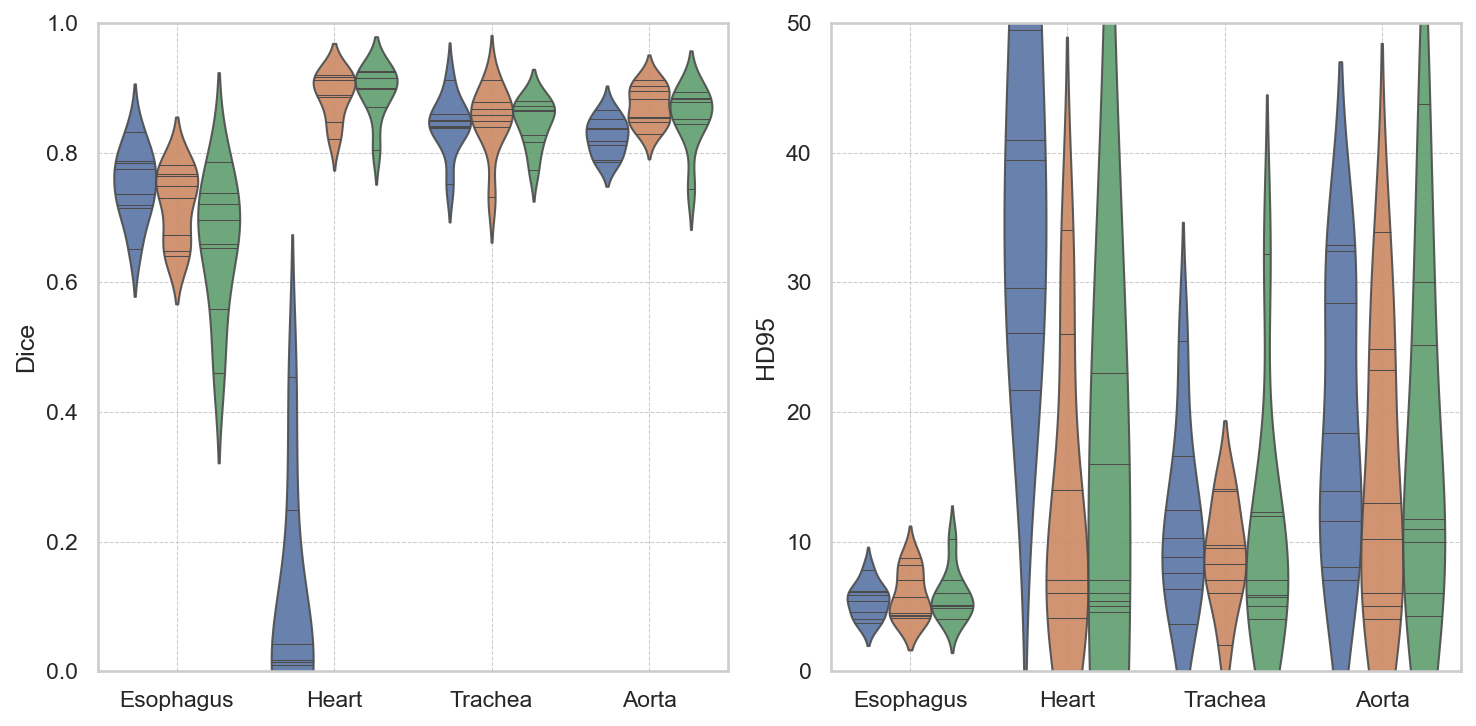

In [43]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].set(ylabel="Dice", ylim=(0, 1))
ax[1].set(ylabel="HD95", ylim=(0, 50))


store_0 = np.load(experiments[0] / "dice_pred.npy")
store_0 = store_0[:, 1:]  # Exclude background

store_2 = np.load(experiments[2] / "dice_pred.npy")
store_2 = store_2[:, 1:]  # Exclude background

store_4 = np.load(experiments[4] / "dice_pred.npy")
store_4 = store_4[:, 1:]  # Exclude background

df = pd.concat(
    [
        pd.DataFrame(store_0, columns=categories[1:]).assign(Experiment="Zero-shot"),
        pd.DataFrame(store_2, columns=categories[1:]).assign(Experiment="Dice+CE"),
        pd.DataFrame(store_4, columns=categories[1:]).assign(Experiment="Dice+Focal"),
    ]
)

# Convert dataframe from wide-form to long-form
df_long = pd.melt(df, id_vars=["Experiment"], var_name="Category", value_name="Dice")
# Create a violin plot


sns.violinplot(
    data=df_long,
    x="Category",
    y="Dice",
    hue="Experiment",
    density_norm="count",
    native_scale=True,
    linewidth=1,
    common_norm=False,
    # split=True,
    inner="stick",
    alpha=0.9,
    ax=ax[0]
)


store_0 = np.load(experiments[0] / "hd95_pred.npy")
store_0 = store_0[:, 1:]  # Exclude background

store_2 = np.load(experiments[2] / "hd95_pred.npy")
store_2 = store_2[:, 1:]  # Exclude background

store_4 = np.load(experiments[4] / "hd95_pred.npy")
store_4 = store_4[:, 1:]  # Exclude background

df = pd.concat(
    [
        pd.DataFrame(store_0, columns=categories[1:]).assign(Experiment="Zero-shot"),
        pd.DataFrame(store_2, columns=categories[1:]).assign(Experiment="Dice+CE"),
        pd.DataFrame(store_4, columns=categories[1:]).assign(Experiment="Dice+Focal"),
    ]
)

# Convert dataframe from wide-form to long-form
df_long = pd.melt(df, id_vars=["Experiment"], var_name="Category", value_name="HD95")
# Create a violin plot


sns.violinplot(
    data=df_long,
    x="Category",
    y="HD95",
    hue="Experiment",
    density_norm="count",
    native_scale=True,
    linewidth=1,
    common_norm=False,
    # split=True,
    inner="stick",
    alpha=0.9,
    ax=ax[1]
)

# Don't display legends
for _ax in ax.flatten():
    _ax.get_legend().remove()
    _ax.set_xlabel('')
    _ax.grid(True, which='both', axis='both', linestyle='--', linewidth=0.5)


plt.tight_layout()
save_dir = curdir / MODEL_NAME / "dice_zeroshot_vs_ft.pdf"
plt.savefig(save_dir, bbox_inches="tight")

In [118]:
# We need a table of the shape
# --------------
# Method | Class 1 | Class 2 | Class 3 | Class 4 | Mean
#        | DICE/HD | DICE/HD | DICE/HD | DICE/HD | DICE/HD
# --------------
# ENet w/ D+CE   | --
# Enet w/ D+F    | Mean+-std
# ENet w/ D
# --------------
# SegVol Zero-shot
# SegVol w/ D+CE
# SegVol w/ D+CE=Aug
# SegVol w/ D+F
# SegVol w/ D+F+Aug
# --------------
# nnUNet w/ D+CE
# nnUNet w/ D+F
# nnUNet w/ D+F+Aug
# --------------

rows = []
# Process each method and its corresponding experiment file
for method, exp_path in methods:
    # Load DICE and HD data
    npy_path = exp_path / "dice_pred.npy"
    if not npy_path.exists():
        continue
        
    dice_data = np.load(npy_path)
    hd_data = np.load(exp_path / "hd95_pred.npy")
    # hd_data = np.ones_like(dice_data) * np.nan

    # Create DataFrames for DICE and HD
    dice_df = pd.DataFrame(dice_data, columns=categories) * 100
    hd_df = pd.DataFrame(hd_data, columns=categories)
    df = dice_df.join(hd_df, lsuffix="_DICE", rsuffix="_HD")
    df = df.drop(columns=['Background_DICE', 'Background_HD'])
    df["Method"] = method
    rows.append(df)

# Combine DICE and HD data under a common multiindex
df = pd.concat(rows)
df = df.groupby("Method").agg(["mean", "std"])


# Add means for the total DICE and HD
for metric in ["DICE", "HD"]:
    df.loc[:, ("Total_" + metric, "mean")] = df[[col for col in df.columns if metric in col[0] and "mean" in col[1]]].mean(axis=1)
    df.loc[:, ("Total_" + metric, "std")] = df[[col for col in df.columns if metric in col[0] and "std" in col[1]]].mean(axis=1)

# Combine mean and std for each metric into a single column with mean±std
for col in df.columns.levels[0]:
    if col != 'Method':
        df[(col, 'mean±std')] = df.apply(lambda x: f"{x[(col, 'mean')]:0>5.2f}±{x[(col, 'std')]:.2f}", axis=1)

# Drop the original mean and std columns
df = df.drop(columns=[(col, stat) for col in df.columns.levels[0] if col != 'Method' for stat in ['mean', 'std']])
# Reorder columns to have mean±std columns together
df = df[[col for col in df.columns if 'mean±std' in col]]

# Rename columns to remove the multi-index
df.columns = [col[0] for col in df.columns]

# Combine DICE and HD data under a common multiindex
df.columns = pd.MultiIndex.from_tuples([(col.split('_')) for col in df.columns])

# Reorder columns to have DICE and HD together
df = df.reindex(columns=pd.MultiIndex.from_product([categories[1:] + ["Total"], ['DICE', 'HD']]))

# Print the final DataFrame
df = df.reset_index()
df

Method    Esophagus                    Heart               \
                              DICE          HD         DICE           HD   
0    SegVol Zero-shot   75.01±5.59  05.46±1.33  09.82±16.63  42.56±17.31   
1      SegVol w/ D+CE   79.01±5.59  04.76±1.33   81.31±2.95   12.05±5.35   
2  SegVol w/ D+CE+Aug   71.90±5.65  05.87±1.88   88.87±3.65  12.78±11.27   
3       SegVol w/ D+F   71.99±5.54  05.69±1.90   88.96±4.30  12.34±11.13   
4   SegVol w/ D+F+Aug  65.88±10.48  05.90±1.95   89.40±4.04  22.37±36.81   

      Trachea                   Aorta                    Total               
         DICE          HD        DICE           HD        DICE           HD  
0  84.26±4.40  11.39±6.93  82.44±2.85  19.06±10.73  62.88±7.37   19.62±9.07  
1  88.26±4.40  10.69±6.93  86.44±2.85  18.36±10.73  83.75±3.95   11.47±6.08  
2  84.91±5.25  08.81±4.01  87.24±2.97  15.02±11.02  83.23±4.38   10.62±7.05  
3  85.23±4.27  10.23±6.44  88.01±2.59   13.16±9.37  83.55±4.17   10.35±7.21  
4  84.54±3.67  10.51±9.30  85.41±4.79  17.74±13.86  81.31±5.74  14.13±15.48

In [119]:

def get_keyerror(x):
    try:
        return x[1]
    except KeyError:
        return x

def get_latex(df: pd.DataFrame, metrics: list[tuple[str, bool]]):
    # Convert the DataFrame to LaTeX format
    # Highlight the maximum value in each column, excluding the first column
    style = df.style.hide(axis=0)
    
    for m, higher_is_better in metrics:
        if higher_is_better:
            style.highlight_max(subset=list(filter(lambda x: m in get_keyerror(x), df.columns[1:])), props="font-weight:bold")
            style.highlight_quantile(q_left=0.999, q_right=0.9999, interpolation="lower", subset=list(filter(lambda x: m in get_keyerror(x), df.columns[1:])), props="font-style:oblique")
        else:
            style.highlight_min(subset=list(filter(lambda x: m in get_keyerror(x), df.columns[1:])), props="font-weight:bold")
            style.highlight_quantile(q_left=0.0001, q_right=0.001,interpolation="higher", subset=list(filter(lambda x: m in get_keyerror(x), df.columns[1:])), props="font-style:oblique")
        
    latex_output = (
        style
        .to_latex(column_format="l" + "r" * (len(df.columns)-1), convert_css=True, hrules=True)
        .replace("nan±nan", "--")
        .replace(r"{r}", r"{c}")
    )

    for m, _ in metrics:
        latex_output = latex_output.replace(m, m + r" $\uparrow$" if _ else m + r" $\downarrow$")

    # Remove leading zeros from the LaTeX output
    latex_output = re.sub(
        r"\s*[^.]0+(\d+)\.", r" \1.", latex_output
    )
    # Make the underline cover the entire cell
    latex_output = re.sub(
        r"\\slshape\s(.+?)\s+([&\\])", r"\\underline{\1} \2", latex_output
    )
    return latex_output

latex_output = get_latex(df, [("DICE", True), ("HD", False)])
latex_output = latex_output.replace("SegVol", r"__1", 1).replace("SegVol", r"\hspace{0.1in}").replace("__1", "SegVol")
print(latex_output)


\begin{tabular}{lrrrrrrrrrr}
\toprule
Method & \multicolumn{2}{c}{Esophagus} & \multicolumn{2}{c}{Heart} & \multicolumn{2}{c}{Trachea} & \multicolumn{2}{c}{Aorta} & \multicolumn{2}{c}{Total} \\
 & DICE $\uparrow$ & HD $\downarrow$ & DICE $\uparrow$ & HD $\downarrow$ & DICE $\uparrow$ & HD $\downarrow$ & DICE $\uparrow$ & HD $\downarrow$ & DICE $\uparrow$ & HD $\downarrow$ \\
\midrule
SegVol Zero-shot & \underline{75.01±5.59} & \underline{5.46±1.33} & 9.82±16.63 & 42.56±17.31 & 84.26±4.40 & 11.39±6.93 & 82.44±2.85 & 19.06±10.73 & 62.88±7.37 & 19.62±9.07 \\
\hspace{0.1in} w/ D+CE & \bfseries 79.01±5.59 & \bfseries 4.76±1.33 & 81.31±2.95 & \bfseries 12.05±5.35 & \bfseries 88.26±4.40 & 10.69±6.93 & 86.44±2.85 & 18.36±10.73 & \bfseries 83.75±3.95 & 11.47±6.08 \\
\hspace{0.1in} w/ D+CE+Aug & 71.90±5.65 & 5.87±1.88 & 88.87±3.65 & 12.78±11.27 & 84.91±5.25 & \bfseries 8.81±4.01 & \underline{87.24±2.97} & \underline{15.02±11.02} & 83.23±4.38 & \underline{10.62±7.05} \\
\hspace{0.1in} w/ D+F & 71

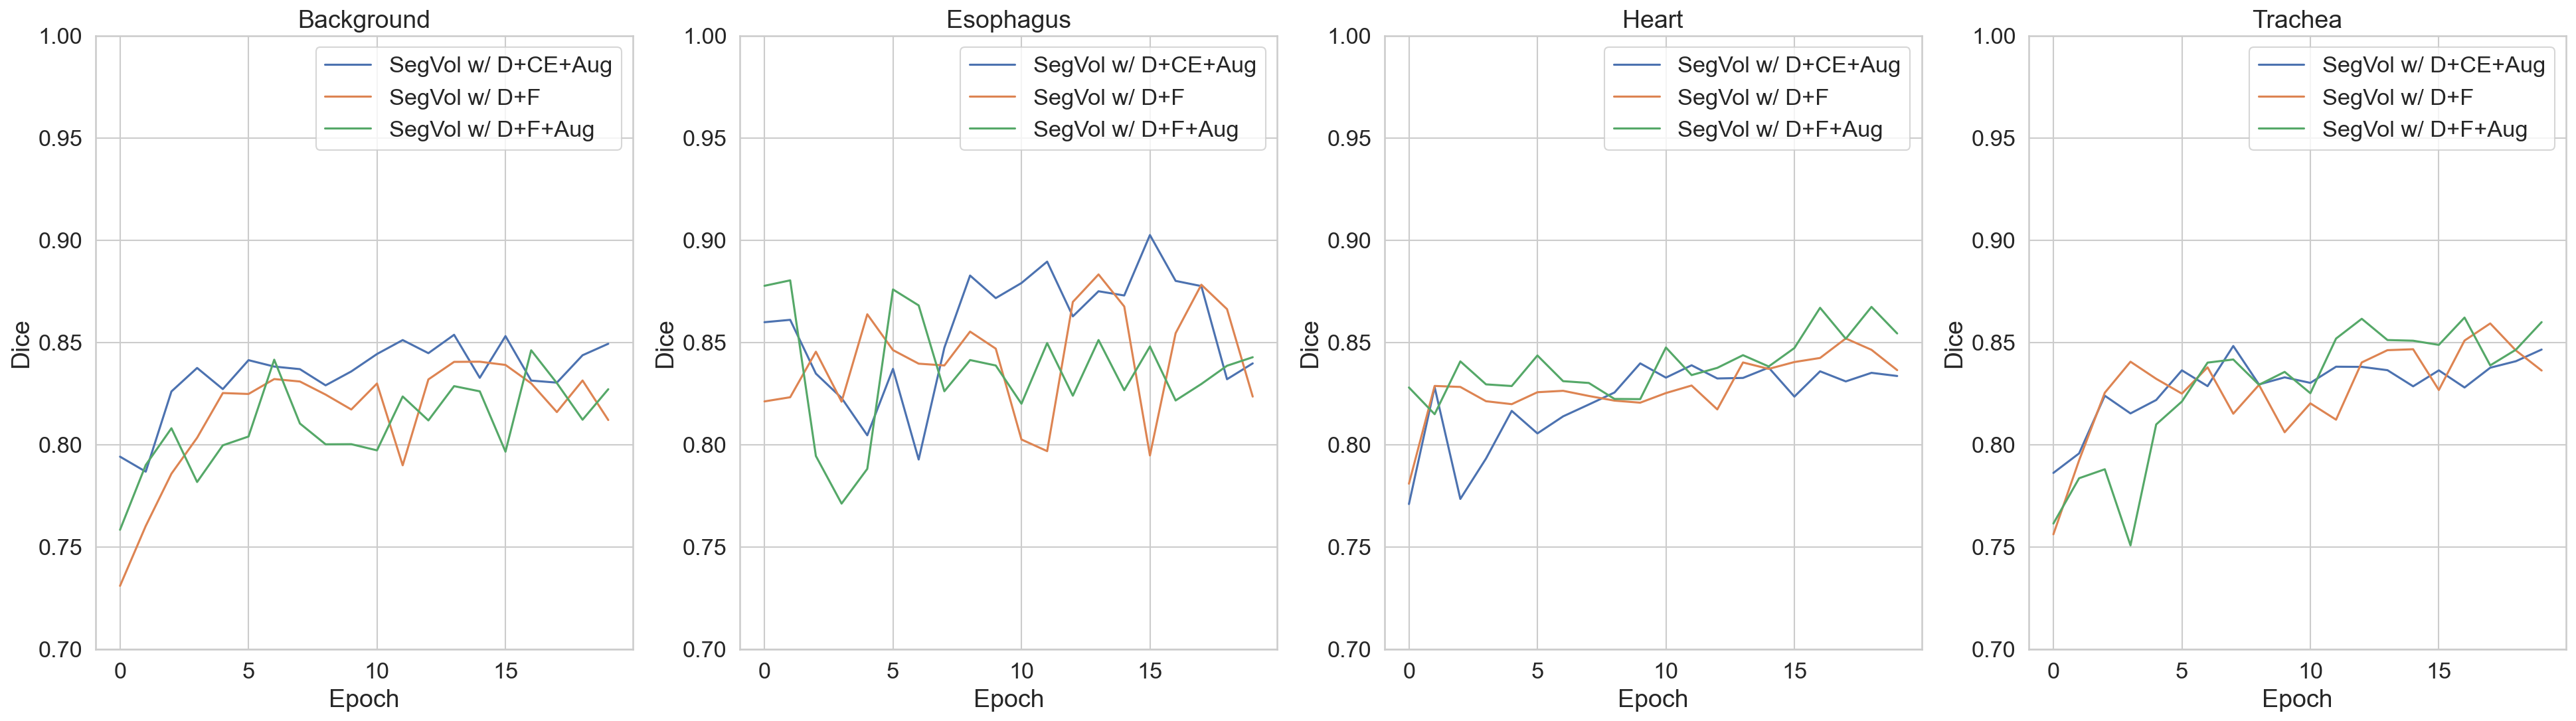

In [103]:

fig, axs = plt.subplots(1, 4, figsize=(32, 8))
for name, experiment in methods[2:]:
    dice = np.load(experiment / "dice_val.npy")[:20, :, :]
    hd95 = np.load(experiment / "hd95_val.npy")[:20, :, :]
    for i in range(len(axs)):
        axs[i].plot(dice[:, i].mean(axis=-1), label=name)

for i in range(len(axs)):
    axs[i].set_title(categories[i])
    axs[i].set_xlabel("Epoch")
    axs[i].set_ylabel("Dice")
    axs[i].set_ylim(0.7, 1)
    axs[i].legend()
plt.legend()